In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
import rubin_sim
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline
rubin_sim.__version__

'1.3.2'

In [2]:
from os import path
opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
nside=64

In [3]:
# The next two lines are used later, when we want to impose a cut based on the level of dust to avoid the plane.
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()

# Here we define a function for some of the metric plots we want to show.
def metric_plots(use_run_name, use_opsim_fname, use_metric=maf.ExgalM5(), use_color_min=None, use_color_max=None,
                year=10, use_filter="i"):
    # use_run_name says which OpSim DB we want to use, e.g. `baseline_v2.1_10yrs` - will also be used for labels
    # use_opsim_fname says where it lives, e.g. `/global/cfs/cdirs/lsst/groups/CO/rubin_sim/sim_baseline/baseline_v2.1_10yrs.db`
    days = year*365.25
    # Here we put the constraint on use of i-band data, exclusion of DDFs, time limitations, and avoiding twilight exposures 
    # Also dec>-20 constraint goes here.
    constraint_str='filter="YY" and note not like "DD%" and night <= XX and note not like "twilight_neo" and fieldDec>-20'
    constraint_str = constraint_str.replace('XX','%d'%days)
    constraint_str = constraint_str.replace('YY','%s'%use_filter)
    
    # Just some optional plotting stuff
    if use_color_min is not None and use_color_max is not None:
        plot_dict={"color_min": use_color_min, "color_max": use_color_max, "x_min": use_color_min, "x_max": use_color_max}
    else:
        plot_dict=None
        
    # Decide what summary statistics we want
    my_summary_stats = [maf.MedianMetric(), maf.MeanMetric(), maf.RmsMetric(), maf.PercentileMetric(percentile=5), maf.PercentileMetric(percentile=25), maf.PercentileMetric(percentile=75)]
    
    # First, define a MetricBundle object.
    depth_map_bundle = maf.MetricBundle(
        metric=use_metric,
        # Exclude the galactic plane here!
        slicer=maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=np.where(map_labels == "lowdust")[0]),
        constraint=constraint_str,
        run_name=use_run_name,
        summary_metrics=my_summary_stats,
        plot_dict=plot_dict
    )
    
    bd = maf.metricBundles.make_bundles_dict_from_list([depth_map_bundle])
    bgroup = maf.MetricBundleGroup(
        bd, use_opsim_fname
    )
    bgroup.run_all()
    return bgroup, bd


In [4]:
v33_sim_list = ['/pscratch/sd/r/rhlozek/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db'#,
           #'/pscratch/sd/r/rhlozek/rubin_sim_data/noroll/noroll_v3.3_10yrs.db'
               ]
v33_name_list = [path.splitext(path.basename(sim))[0] for sim in v33_sim_list]

In [5]:
# First define a routine to run across a list of years and produce a dataframe
def get_year_by_year_metrics(year_list, name_list, sim_list, filter_list, use_metric=maf.ExgalM5()):
    overall_names = []
    overall_years = []
    overall_meds = []
    overall_means = []
    overall_std = []
    overall_iqr = []
    overall_filters = []
    overall_5p = []
    for year in year_list:
        for i in range(len(sim_list)):
            for filter in filter_list:
                bgroup, bd = metric_plots(name_list[i], sim_list[i], year=year, use_filter=filter, use_metric=use_metric)
                overall_names.append(name_list[i])
                overall_years.append(year)
                overall_filters.append(filter)
                overall_meds.append(bd[list(bd.keys())[0]].summary_values['Median'])
                overall_means.append(bd[list(bd.keys())[0]].summary_values['Mean'])
                overall_std.append(bd[list(bd.keys())[0]].summary_values['Rms'])
                overall_5p.append(bd[list(bd.keys())[0]].summary_values['5th%ile'])
                overall_iqr.append(bd[list(bd.keys())[0]].summary_values['75th%ile']-bd[list(bd.keys())[0]].summary_values['25th%ile'])
    df = pd.DataFrame(list(zip(overall_names, overall_years, overall_filters, overall_meds, overall_means, overall_std, overall_iqr, overall_5p)), 
                  columns=['Strategy', 'Year', 'Filter', 'Median depth', 'Mean depth', 'Std depth', 'IQR depth', '5th %ile'])
    return df

In [6]:
# Note that Coaddm5Metric() gives 5-sigma point-source coadded depths, while ExgalM5 applies extinction correction.
desi_df = get_year_by_year_metrics(np.arange(1,3), v33_name_list, v33_sim_list, 
                                   ["u","g","r","i"], use_metric=maf.Coaddm5Metric())
display(desi_df)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


,Strategy,Year,Filter,Median depth,Mean depth,Std depth,IQR depth,5th %ile
0,baseline_v3.3_10yrs,1,u,24.318188,24.300083,0.312120,0.396599,23.775739
1,baseline_v3.3_10yrs,1,g,25.611716,25.577666,0.271980,0.327877,25.115371
2,baseline_v3.3_10yrs,1,r,25.739930,25.701264,0.244036,0.220563,25.369780
3,baseline_v3.3_10yrs,1,i,25.315014,25.270030,0.248290,0.214797,24.926487
4,baseline_v3.3_10yrs,2,u,24.539040,24.502355,0.269329,0.327789,24.051840
5,baseline_v3.3_10yrs,2,g,25.935350,25.886007,0.287006,0.311777,25.392092
6,baseline_v3.3_10yrs,2,r,26.114498,26.050714,0.296343,0.265010,25.585019
7,baseline_v3.3_10yrs,2,i,25.682680,25.613106,0.288944,0.261898,25.178033


In [8]:
desi_df.to_pickle('desi_dataframe_decgt-20.pkl')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


,Median,Mean,Rms,25th%ile,75th%ile
baseline_v3_3_10yrs_CoaddM5_u_and_note_not_like_DD_and_night_lt_365_and_note_not_like_twilight_neo_and_fieldDecgt-20_HEAL,24.318188,24.300083,0.31212,24.125645,24.522244


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


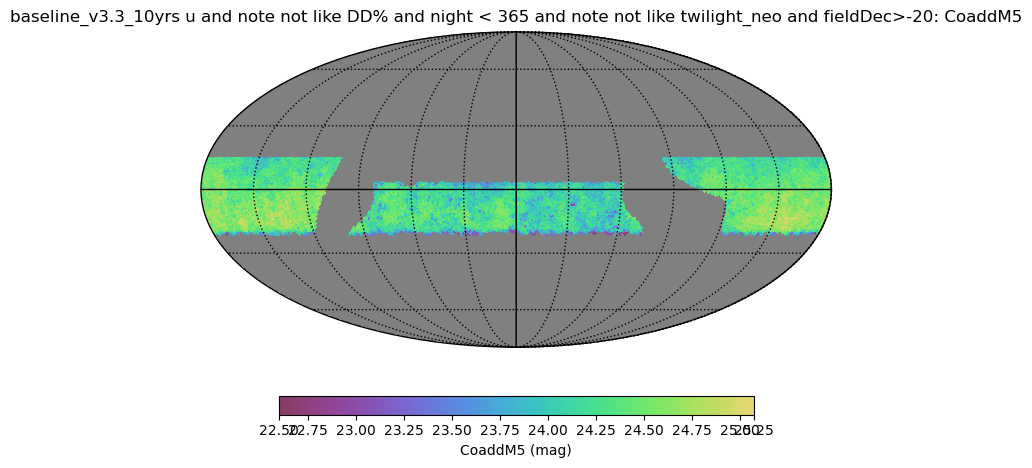

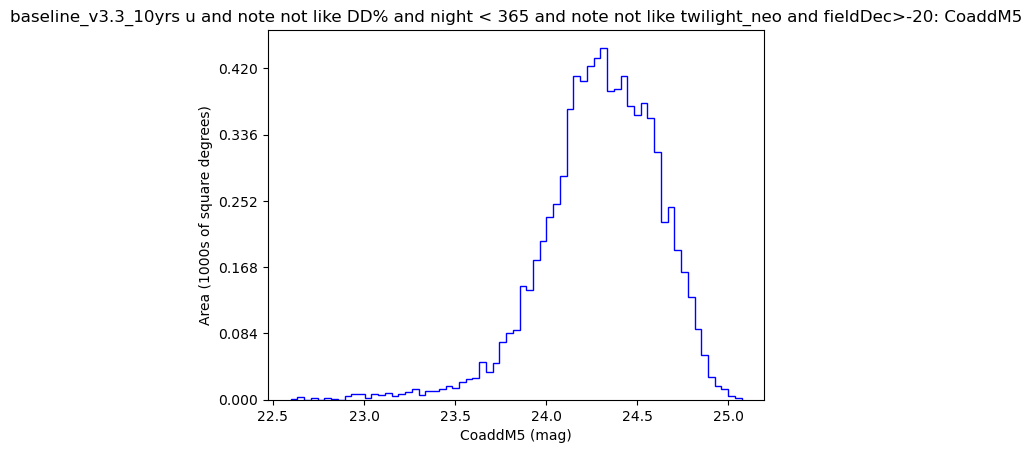

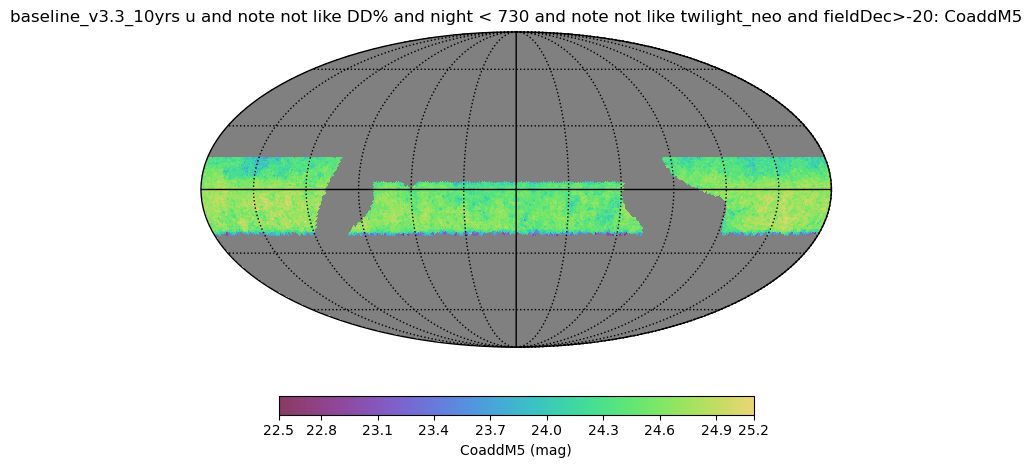

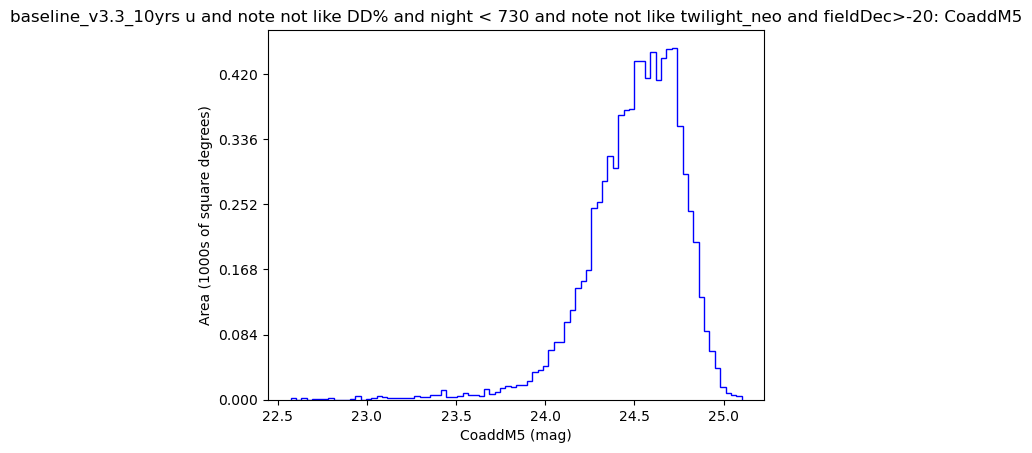

In [49]:
bgroup, bd = metric_plots(v33_name_list[0], v33_sim_list[0], year=1, use_filter="u", use_metric=maf.Coaddm5Metric())
bgroup.plot_all(closefigs=False)
foo = pd.DataFrame([bd[k].summary_values for k in bd], index=list(bd.keys()))
display(foo)
bgroup, bd = metric_plots(v33_name_list[0], v33_sim_list[0], year=2, use_filter="u", use_metric=maf.Coaddm5Metric())
bgroup.plot_all(closefigs=False)

In [47]:
dir(bgroup)
bgroup.db_cols

['rotSkyPos', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']

,Median,Mean,Rms,25th%ile,75th%ile
baseline_v3_3_10yrs_CoaddM5_u_and_note_not_like_DD_and_night_lt_730_and_note_not_like_twilight_neo_HEAL,24.590523,24.576327,0.218783,24.431802,24.73144
